In [1]:
import keras
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import concatenate

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as mt
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix

from keras import backend as K

/hpc/applications/anaconda/3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
plt.style.use('ggplot')
%matplotlib inline

full_df = pd.read_csv('data/diabetic_data.csv')

full_df = full_df.head(10000)


#full_df.dtypes

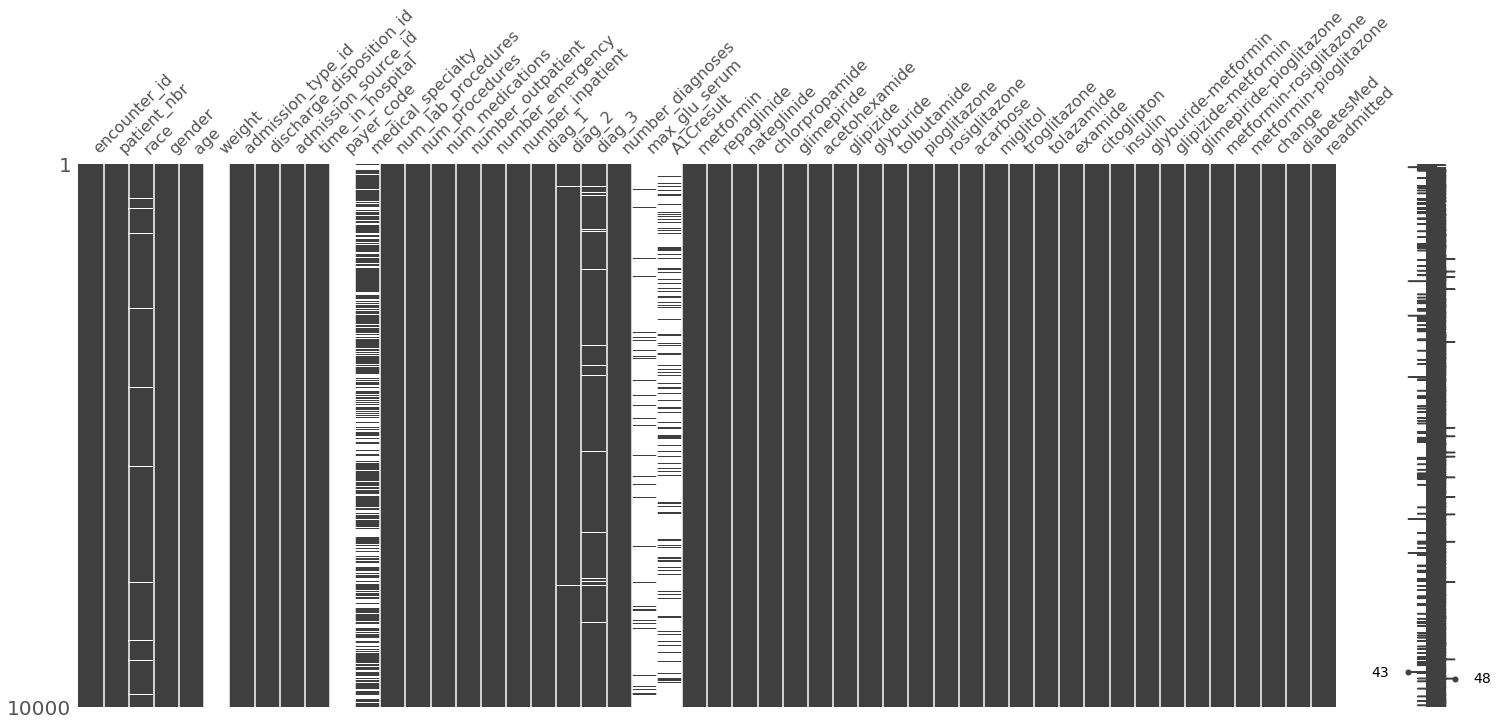

In [3]:
import os
if os.getcwd().find('jamesthomas'):
    import sys
    sys.path.append('/users/jamesthomas/python_packages/')
    import missingno as mn
        
# first force the columns that should be numeric to numeric
numeric_cols = ['weight','payer_code']
full_df[numeric_cols]=full_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# now replace the '?' in the string data
full_df.replace({'?':None,'None':None}, inplace = True)
mn.matrix(full_df)

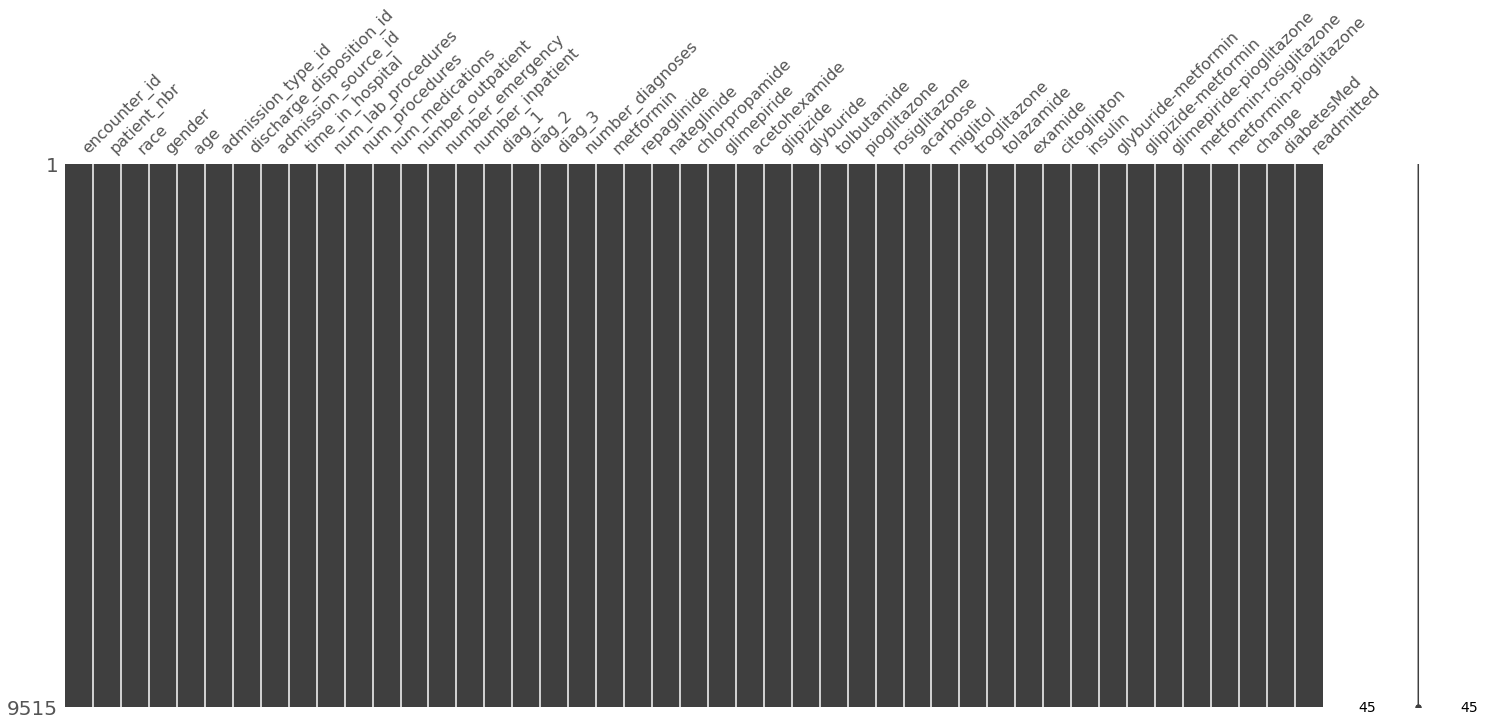

In [4]:
cols = list(full_df)
datas = list(full_df.isnull().sum())
size = full_df.shape[0]
drop_cols = []
threshold = 0.08
for i in range(len(cols)):
    if datas[i]/size > threshold:
        drop_cols.append(cols[i])

full_df.drop(drop_cols, axis=1, inplace=True)
full_df.dropna(inplace=True)
mn.matrix(full_df)

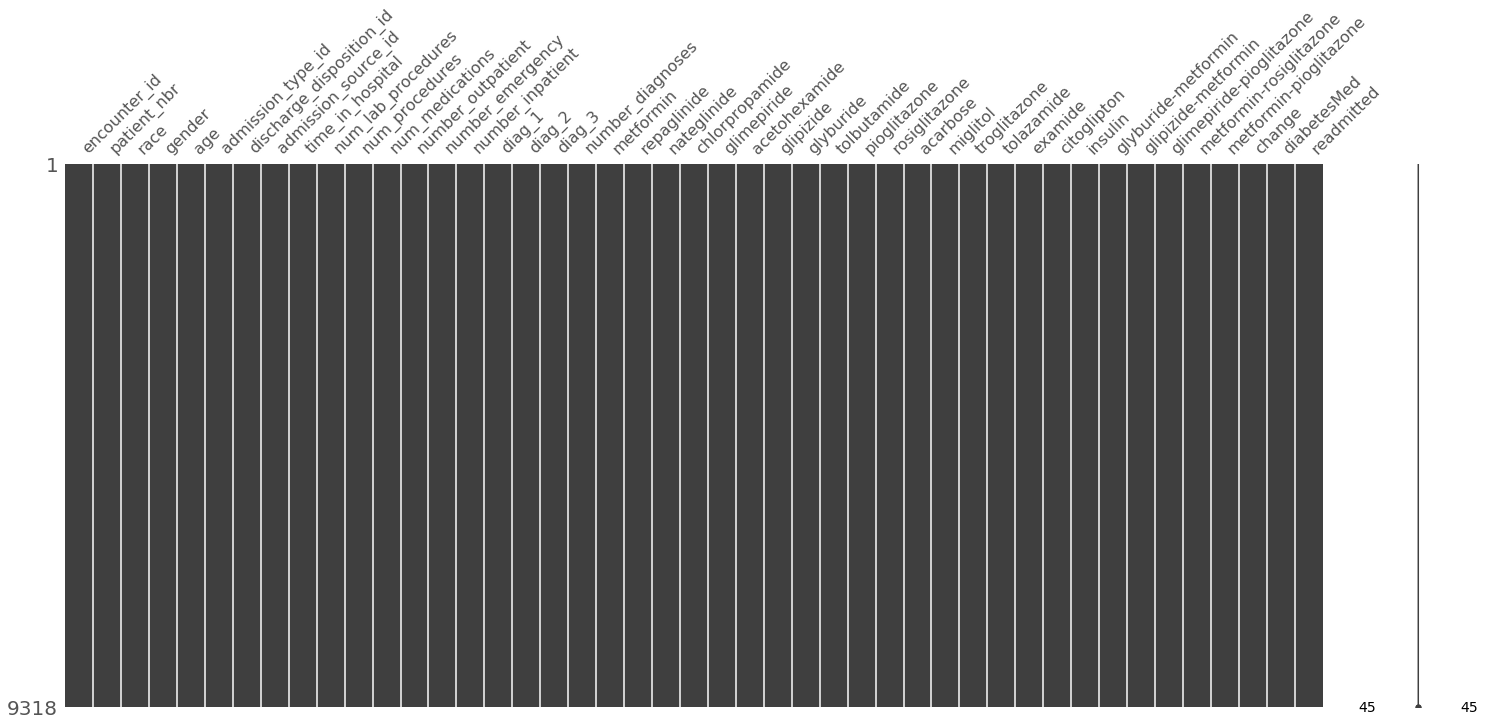

In [5]:
discharge_disp_ids = [11, 13, 14, 19, 20, 21]
full_df = full_df.loc[~full_df.discharge_disposition_id.isin(discharge_disp_ids)]
mn.matrix(full_df)

In [6]:
# some helper functions for data conversion
def one_hot_encode(df, column):
    '''If the column only contains a single value, there is no information so don't do anything,
    otherwise one hot encode the column
    '''
    col_names = []
    if len(df[col].unique()) != 1:
        # more than one value in category
        df[column] = pd.Categorical(df[column])
        dfDummies = pd.get_dummies(df[column], prefix = column+'_category', drop_first=True) # added drop_first
        col_names.append(list(dfDummies))
        df = pd.concat([df, dfDummies], axis=1)
    return df, col_names

def diag_categorize(val):
    '''More information about the categories can be found at http://www.icd9data.com/
    '''
    try:
        val = float(val)
        if val < 140:
            return('Infectious and Parasitic Disease')
        elif val < 240:
            return('Neoplasms')
        elif val < 280:
            return('Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders')
        elif val < 290:
            return('Diseases Of The Blood And Blood-Forming Organs')
        elif val < 320:
            return('Mental Disorders')
        elif val < 390:
            return('Diseases Of The Nervous System And Sense Organs')
        elif val < 460:
            return('Diseases Of The Circulatory System')
        elif val < 520:
            return('Diseases Of The Circulatory System')
        elif val < 580:
            return('Diseases Of The Digestive System')
        elif val < 630:
            return('Diseases Of The Genitourinary System')
        elif val < 680:
            return('Complications Of Pregnancy, Childbirth, And The Puerperium')
        elif val < 710:
            return('Diseases Of The Skin And Subcutaneous Tissue')
        elif val < 740:
            return('Diseases Of The Musculoskeletal System And Connective Tissue')
        elif val < 760:
            return('Congenital Anomalies')
        elif val < 780:
            return('Certain Conditions Originating In The Perinatal Period')
        elif val < 800:
            return('Symptoms, Signs, And Ill-Defined Conditions')
        else:
            return('Injury And Poisoning')
    except:
        if val[0]=='V':
            return('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
        elif val[0]=='E':
            return('Supplementary Classification Of External Causes Of Injury And Poisoning')
        else:
            print(val)
            return(None)
        
def type_id_trans(val):
    return str(val)

In [7]:
explain_list = ['diag_1', 'diag_2', 'diag_3']
for diag in explain_list:
    full_df[diag+'_explain'] = full_df[diag].apply(diag_categorize)
type_id_list = ['admission_type_id','discharge_disposition_id','admission_source_id']
for diag in type_id_list:
    full_df[diag] = full_df[diag].apply(type_id_trans)

In [8]:
# Now we will convert the 'patient_nbr' column to a new column that shows counts how many times the patient visitied
# the hospital in the study
full_df['freq'] = full_df.groupby('patient_nbr')['patient_nbr'].transform('count')

In [9]:
# these are the columns that are no longer relevant, either because we transformed the data or it is just an id
drop_not_relevant = ['encounter_id', 'patient_nbr']
full_df.drop(drop_not_relevant, axis=1, inplace=True)

In [10]:
full_df['age'] = full_df['age'].replace({'[0-10)':0,'[10-20)':1,'[20-30)':2,'[30-40)':3,'[40-50)':4,
                                         '[50-60)':5,'[60-70)':6,'[70-80)':7,'[80-90)':8,'[90-100)':9})

In [11]:
full_df.dropna(inplace=True) # to drop any None types that come up from the conversions

In [12]:
standard_scalar_list = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'freq']

In [13]:
# these are the columns that need one hot encoded
one_hot_encode_list = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
                       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
                       'tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin',
                       'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                       'diag_1_explain','diag_2_explain','diag_3_explain','race','admission_type_id',
                       'discharge_disposition_id','admission_source_id','insulin']
labe_encod_list = ['gender','change','diabetesMed']

In [14]:
from copy import deepcopy
df_train = deepcopy(full_df)
df_test = deepcopy(full_df)

In [15]:
categorical_headers = one_hot_encode_list+labe_encod_list
numeric_headers = standard_scalar_list

In [16]:
# scale the numeric, continuous variables
for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

In [17]:
# define objects that can encode each variable as integer    
encoders = dict() 

#categorical_headers = ['workclass','education','marital_status','occupation','relationship','race','sex','country']

# train all encoders
for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
        # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])

In [18]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
y_test = df_test['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values

#for multi-classification
nb_classes = 3

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [19]:
#cross_columns and wide network

cross_columns = [['admission_type_id','admission_source_id'],
                 ['gender','race']]



# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

In [20]:
#deep network

X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)

# also get a dense branch of the numeric features

all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))


x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

In [21]:
if False:
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot

    # you will need to install pydot properly on your machine to get this running
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [22]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_num],
                    y_train,
                    epochs=100, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

CPU times: user 6min 47s, sys: 1min 30s, total: 8min 17s
Wall time: 3min 20s


Text(0.5,0,'epochs')

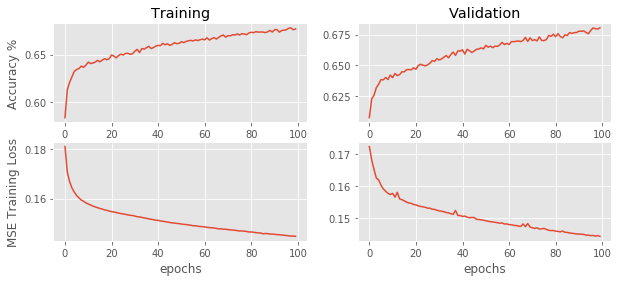

In [23]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [24]:
my_cost_matrix = np.array([[1,  10, 10],
                           [5,  0,  3],
                           [5,  3,  0]])
def convert_back(y):
    tmp = [[i,val] for (i,val) in enumerate(y)]
    tmp = sorted(tmp,key=lambda l:l[1], reverse=True)
    return tmp[0][0]

def find_cost_metric(y_true, y_pred, cost_matrix):
    y_true = [convert_back(y_val) for y_val in y_true]
    y_pred = [convert_back(y_val) for y_val in y_pred]

    conf_matrix = confusion_matrix(y_true, y_pred)

    if cost_matrix is None:
        # check if the user passed a cost matrix
        print('No cost matrix passed, using ones')
        cost_matrix = np.ones(conf_matrix.shape)
    if (cost_matrix < 0).all():
        # make sure they are all positive
        cost_matrix = cost_matrix - np.min(cost_matrix)
    cost_matrix = cost_matrix/len(y_true) # normalize for bounds       
    return(np.sum(conf_matrix * cost_matrix))

In [25]:
yhat = model.predict(X_ints_test + [X_test_num])
cost = find_cost_metric(y_test,yhat,my_cost_matrix)
print(cost)

2.200257566001288


In [26]:
def deep_and_wide(cross_columns,deep_layers):
    
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        enc = LabelEncoder()

        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        N = max(X_ints_train[-1]+1)

        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)
    X_train_num =  df_train[numeric_headers].values
    X_test_num = df_test[numeric_headers].values

    all_deep_branch_outputs = []
    for col in categorical_headers_ints:
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        N = max(X_ints_train[-1]+1)

        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))


    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    
    for nbr,act,name in deep_layers:
        deep_branch = Dense(units=nbr,activation=act, name=name)(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)
    
    return model

In [38]:
class deep_and_wide_all_wraped(object):
    def __init__(self,cross_columns,deep_layers,epochs):
        self.cross_columns = cross_columns
        self.deep_layers = deep_layers
        self.epochs = epochs
    def build_model(self):
        K.clear_session()
        self.model = deep_and_wide(self.cross_columns,self.deep_layers)
        self.model.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
        return self.model
    def fit(self):
        self.build_model()
        self.history = self.model.fit(X_ints_train+ [X_train_num],
                        y_train,
                        epochs=self.epochs, 
                        batch_size=32, 
                        verbose=1, 
                        validation_data = (X_ints_test + [X_test_num], y_test))
        return self.history
    
    def cost_predict(self,X_ints_test,X_test_num):
        yhat = self.model.predict(X_ints_test + [X_test_num])
        cost = find_cost_metric(y_test,yhat,my_cost_matrix)
        return cost
    
    def plt(self):
        plt.figure(figsize=(10,4))
        plt.subplot(2,2,1)
        plt.plot(self.history.history['acc'])

        plt.ylabel('Accuracy %')
        plt.title('Training')
        plt.subplot(2,2,2)
        plt.plot(self.history.history['val_acc'])
        plt.title('Validation')

        plt.subplot(2,2,3)
        plt.plot(self.history.history['loss'])
        plt.ylabel('MSE Training Loss')
        plt.xlabel('epochs')

        plt.subplot(2,2,4)
        plt.plot(self.history.history['val_loss'])
        plt.xlabel('epochs')

Train on 9318 samples, validate on 9318 samples
Epoch 1/10
9318/9318 [==============================] - 3s 315us/step - loss: 0.1788 - acc: 0.5871 - val_loss: 0.1751 - val_acc: 0.5895
Epoch 2/10
9318/9318 [==============================] - 2s 217us/step - loss: 0.1699 - acc: 0.6138 - val_loss: 0.1683 - val_acc: 0.6125
Epoch 3/10
9318/9318 [==============================] - 2s 217us/step - loss: 0.1670 - acc: 0.6192 - val_loss: 0.1660 - val_acc: 0.6186
Epoch 4/10
9318/9318 [==============================] - 2s 217us/step - loss: 0.1653 - acc: 0.6226 - val_loss: 0.1636 - val_acc: 0.6277
Epoch 5/10
9318/9318 [==============================] - 2s 216us/step - loss: 0.1639 - acc: 0.6262 - val_loss: 0.1626 - val_acc: 0.6289
Epoch 6/10
9318/9318 [==============================] - 2s 216us/step - loss: 0.1625 - acc: 0.6281 - val_loss: 0.1614 - val_acc: 0.6328
Epoch 7/10
9318/9318 [==============================] - 2s 216us/step - loss: 0.1614 - acc: 0.6304 - val_loss: 0.1609 - val_acc: 0.6319


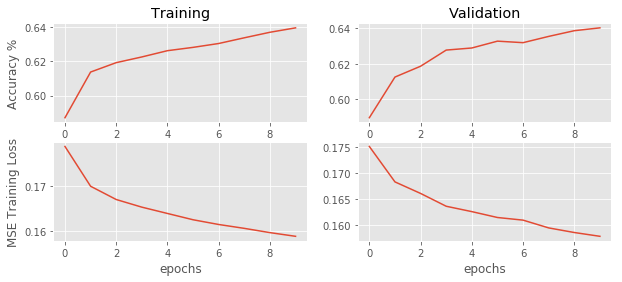

In [39]:
cross_columns = [['admission_type_id','admission_source_id'],  ['gender','race']]
deep_layers = [[50,'relu','deep1'],[25,'relu','deep2'],[10,'relu','deep3']]

model = deep_and_wide_all_wraped(cross_columns,deep_layers,epochs=10)
hist1 = model.fit()
model.plt()
cost = model.cost_predict(X_ints_test,X_test_num)
print(cost)